<a href="https://colab.research.google.com/github/mentalinvestor/emp/blob/main/EMP_%EB%A7%88%EC%8A%A4%ED%84%B0_%ED%95%9C%EA%B8%80%ED%8C%90_%EC%99%84%EC%84%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== 전략적 포트폴리오 최적화 분석 ===

1. 자산배분 전략
       현재 비중  최대 수익률 최소 연간손실
GLD    5.00%  15.00%  15.00%
BOTZ   4.00%  15.00%   3.00%
AIQ    4.00%  15.00%   3.00%
ARKK   4.00%  15.00%   3.00%
GAA    5.00%   3.00%   4.00%
GMOM  17.00%   3.00%  15.00%
QQQ    7.00%  15.00%   3.00%
TLT    5.00%   3.00%   3.00%
TIP   15.00%   3.00%   3.00%
SDY    5.00%   3.00%  15.00%
DVY    5.00%   4.00%  15.00%
DIAL  15.00%   3.00%   3.00%
PDBC  15.00%   3.00%  15.00%

2. 성과 분석
        current max_return min_loss
총수익률     73.19%    134.12%   87.04%
연간수익률     9.47%     15.05%   10.87%
최대연간손실  -13.06%    -30.62%   -5.79%
변동성      11.12%     19.28%   12.37%


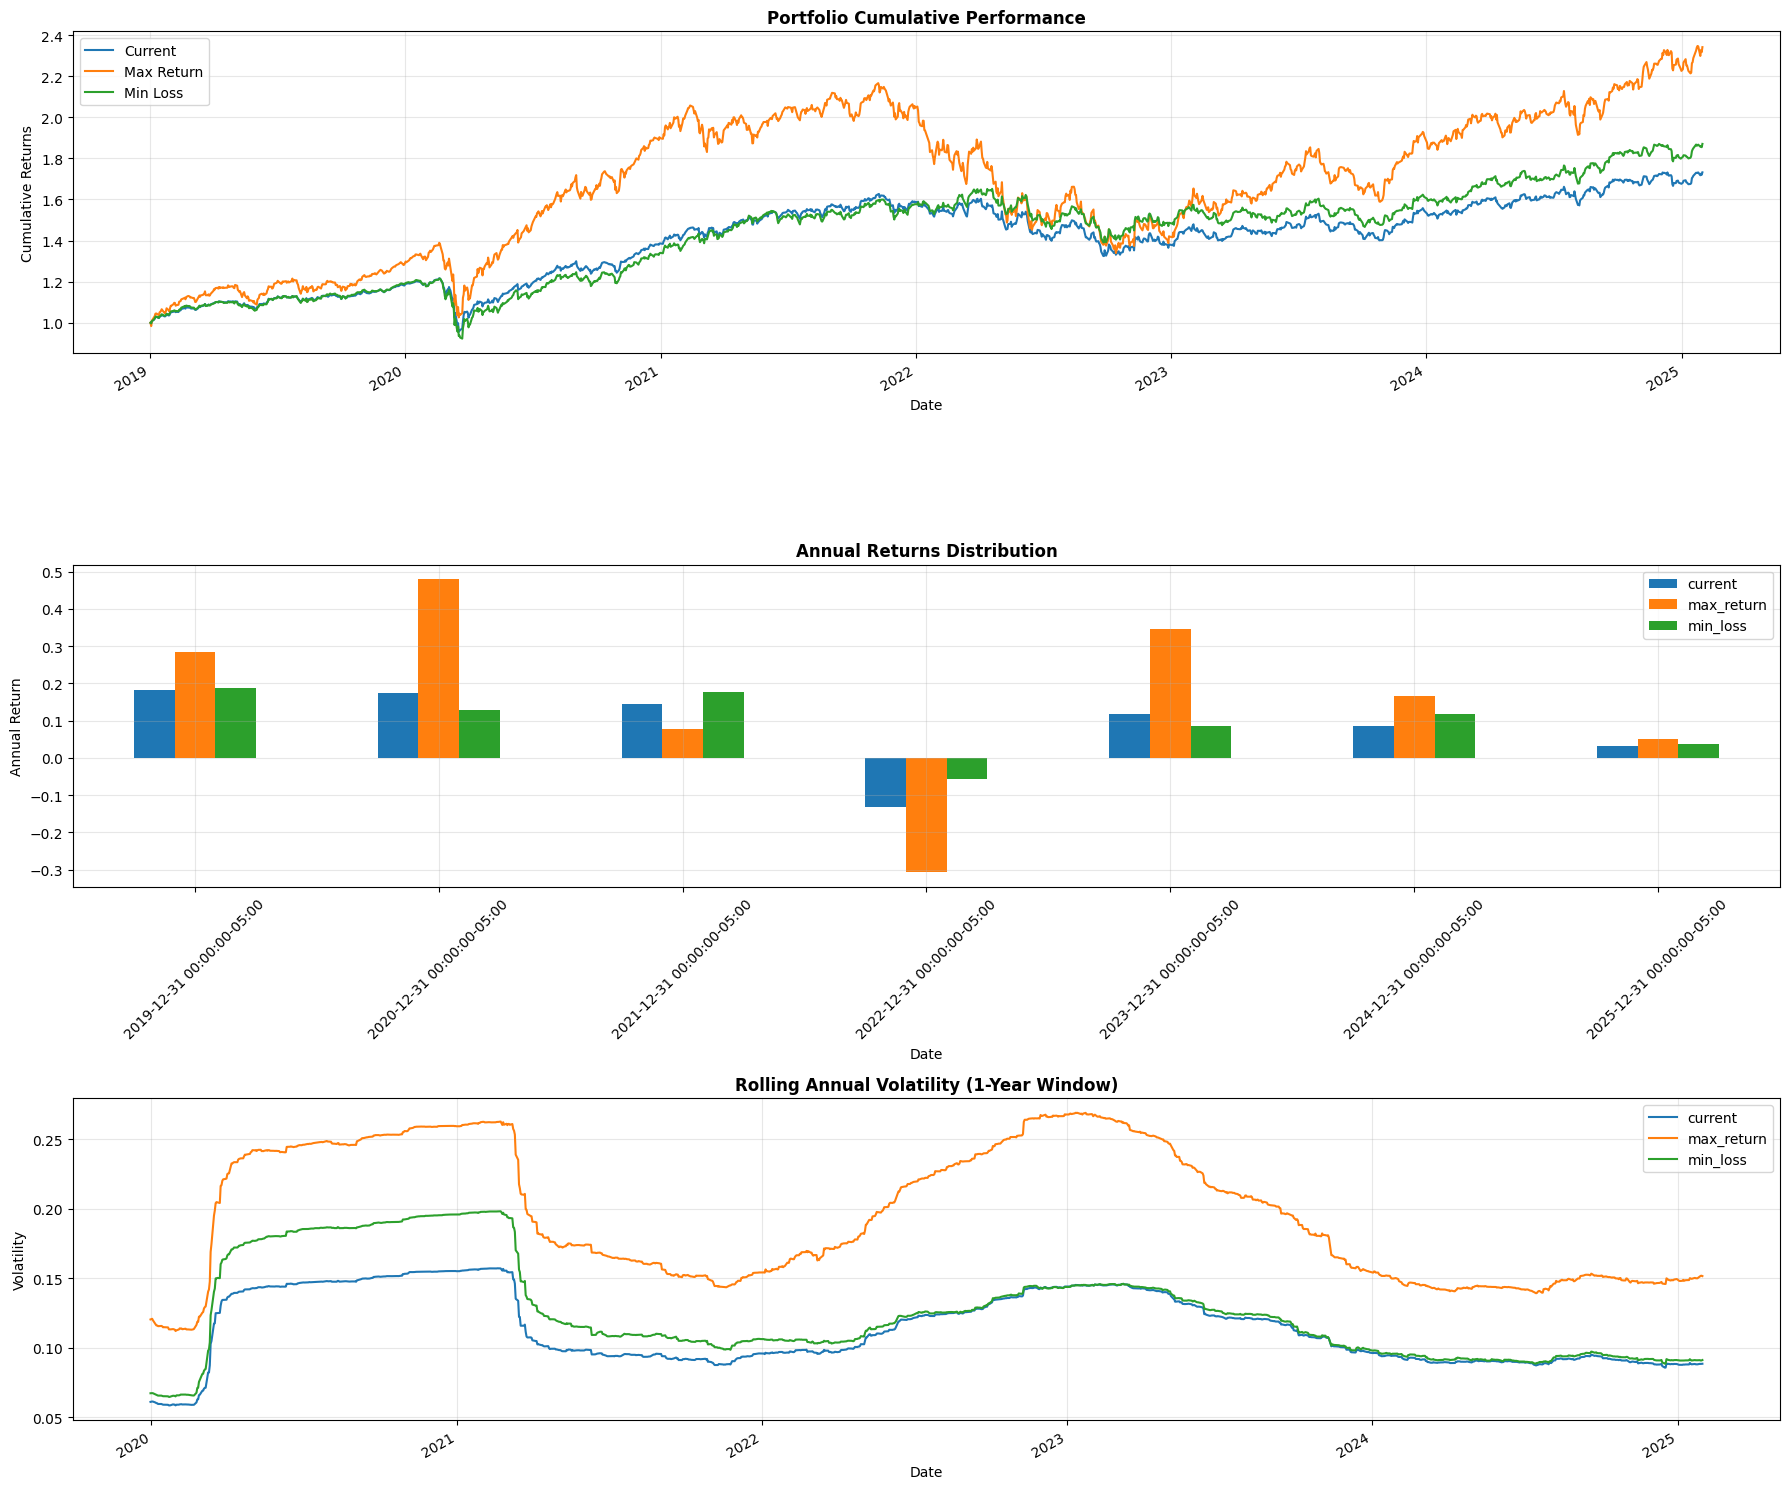

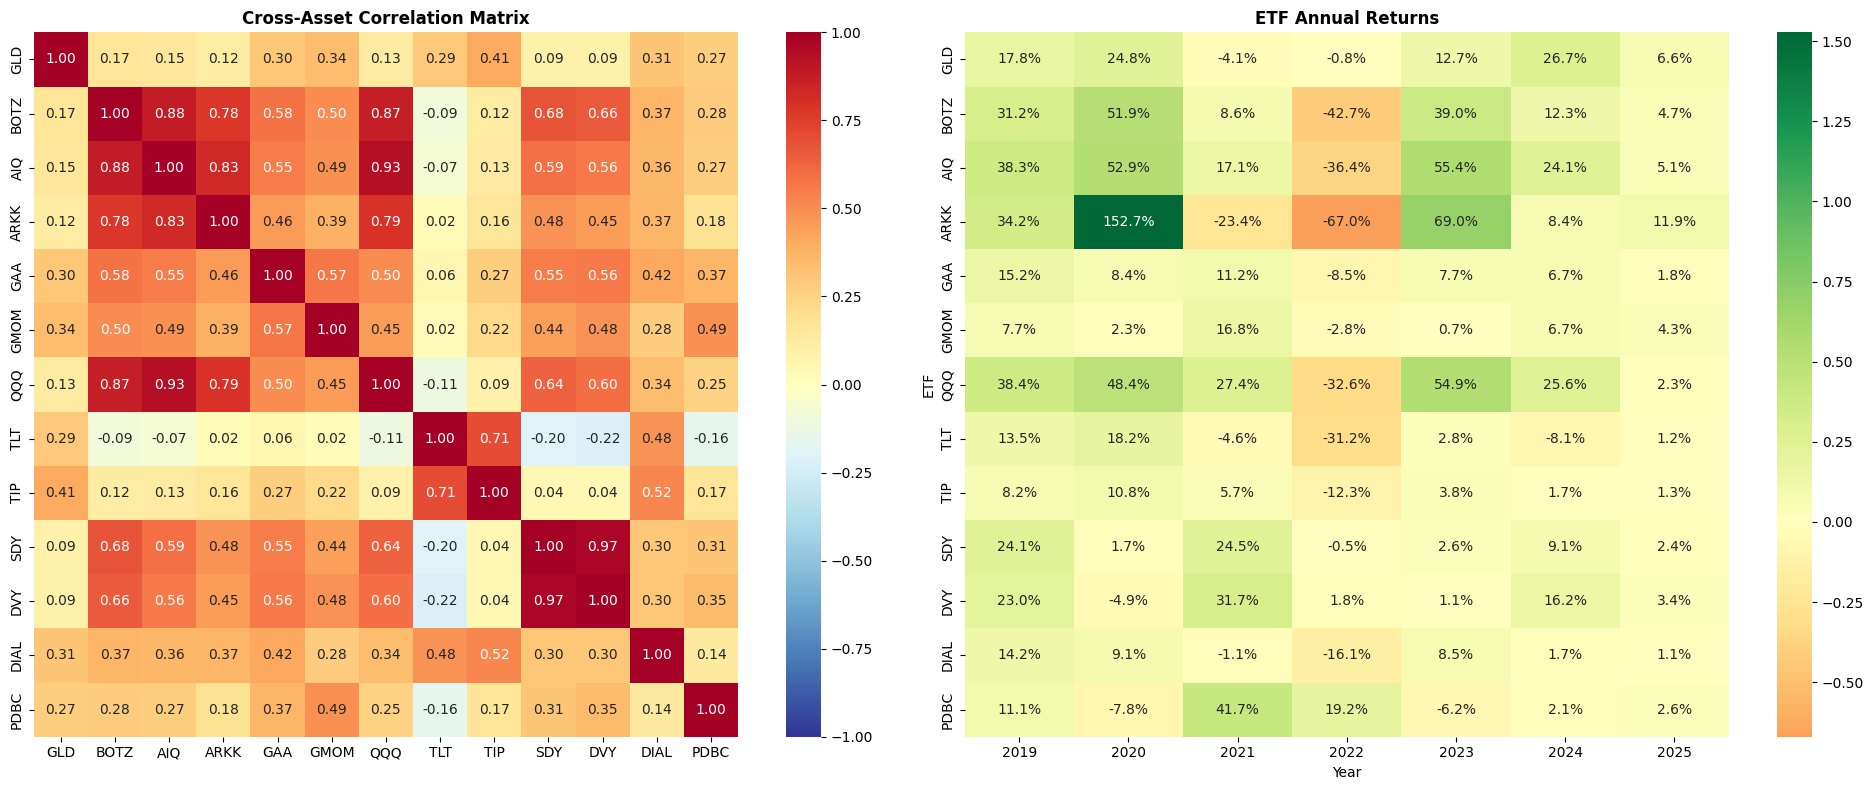


=== 포트폴리오 비용 및 수익 분석 ===
경고: GLD에 대해 예상 운용보수 사용
경고: BOTZ에 대해 예상 운용보수 사용
경고: AIQ에 대해 예상 운용보수 사용
경고: ARKK에 대해 예상 운용보수 사용
경고: GAA에 대해 예상 운용보수 사용
경고: GMOM에 대해 예상 운용보수 사용
경고: QQQ에 대해 예상 운용보수 사용
경고: TLT에 대해 예상 운용보수 사용
경고: TIP에 대해 예상 운용보수 사용
경고: SDY에 대해 예상 운용보수 사용
경고: DVY에 대해 예상 운용보수 사용
경고: DIAL에 대해 예상 운용보수 사용
경고: PDBC에 대해 예상 운용보수 사용

ETF 비용 & 수익 프로필 분석:
          비중   운용보수  배당수익률
GLD    5.00%  0.35%  0.00%
BOTZ   4.00%  0.35%  0.00%
AIQ    4.00%  0.35%  0.00%
ARKK   4.00%  0.75%  0.00%
GAA    5.00%  0.35%  0.00%
GMOM  17.00%  0.35%  0.00%
QQQ    7.00%  0.35%  0.34%
TLT    5.00%  0.35%  2.45%
TIP   15.00%  0.35%  1.16%
SDY    5.00%  0.35%  0.00%
DVY    5.00%  0.35%  2.63%
DIAL  15.00%  0.35%  0.00%
PDBC  15.00%  0.35%  0.00%

포트폴리오 수준 비용-수익 지표:
포트폴리오 가중평균 운용보수: 0.39%
예상 포트폴리오 배당수익률: 0.45%
순 예상 수익률 (비용 차감 후): 0.06%

=== 포트폴리오 투자 분석 요약 ===

투자 예상 분석:
10,000,000원 투자시:
• 예상 연간 운용보수: 38,700원
• 예상 연간 배당수익: 45,129원
• 순 연간 수익 (비용 차감후): 6,429원
• 예상 연간 수익 (백테스트 기준): 947,460원 (9.47%)

=== EMP 포트폴리오 종합 

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import skew, kurtosis
from scipy.optimize import minimize
import requests
from bs4 import BeautifulSoup
import time
import json

class EMPPortfolioBacktest:
    """향상된 멀티에셋 포트폴리오(EMP) 백테스팅 시스템

    정량적 포트폴리오 최적화 프레임워크 - 이중 목표:
    1. 절대 수익률 최대화 (Absolute Return Maximization)
    2. 연간 손실 최소화 (Annual Loss Minimization)

    기관투자자급 포지션 한도 및 리스크 관리 제약조건 구현
    """

    def __init__(self, tickers_weights_dict, start_date='2019-01-01'):
        """
        초기화 함수
        Args:
            tickers_weights_dict (dict): ETF 티커와 비중을 담은 딕셔너리
            start_date (str): 백테스트 시작일
        """
        self.tickers = list(tickers_weights_dict.keys())
        self.weights = list(tickers_weights_dict.values())
        self.start_date = start_date
        self.end_date = datetime.now().strftime('%Y-%m-%d')
        self.expense_data = {}

    def _fetch_expense_ratio_multi_source(self, ticker):
        """
        다중 소스 ETF 운용보수 수집 시스템

        데이터 소스:
        1. Yahoo Finance API
        2. ETF.com 웹스크래핑
        3. ETFdb.com 웹스크래핑
        4. 캐시 데이터 활용
        """
        expense_ratio = 0

        # Source 1: Yahoo Finance
        try:
            etf = yf.Ticker(ticker)
            info = etf.info
            expense_ratio = info.get('annualReportExpenseRatio', 0)
            if expense_ratio:
                expense_ratio = expense_ratio * 100
                self._cache_expense_ratio(ticker, expense_ratio, 'yahoo')
                return expense_ratio
        except Exception as e:
            print(f"Yahoo Finance 데이터 수집 실패 - {ticker}: {str(e)}")

        # Source 2: ETF.com
        try:
            url = f"https://www.etf.com/{ticker}"
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
            }
            response = requests.get(url, headers=headers)
            if response.status_code == 200:
                soup = BeautifulSoup(response.text, 'html.parser')
                expense_elements = soup.find_all(class_='expense-ratio')
                if expense_elements:
                    expense_text = expense_elements[0].text.strip()
                    expense_ratio = float(expense_text.replace('%', ''))
                    self._cache_expense_ratio(ticker, expense_ratio, 'etf.com')
                    return expense_ratio
        except Exception as e:
            print(f"ETF.com 데이터 수집 실패 - {ticker}: {str(e)}")

        # Source 3: ETFdb.com
        try:
            url = f"https://etfdb.com/etf/{ticker}/"
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
            }
            response = requests.get(url, headers=headers)
            if response.status_code == 200:
                soup = BeautifulSoup(response.text, 'html.parser')
                expense_elements = soup.find_all(class_='expense-ratio')
                if expense_elements:
                    expense_text = expense_elements[0].text.strip()
                    expense_ratio = float(expense_text.replace('%', ''))
                    self._cache_expense_ratio(ticker, expense_ratio, 'etfdb')
                    return expense_ratio
        except Exception as e:
            print(f"ETFdb.com 데이터 수집 실패 - {ticker}: {str(e)}")

        # 캐시 데이터 확인
        cached_ratio = self._get_cached_expense_ratio(ticker)
        if cached_ratio:
            print(f"{ticker} - 캐시된 운용보수 데이터 사용")
            return cached_ratio

        # 예상치 반환
        print(f"경고: {ticker}에 대해 예상 운용보수 사용")
        return self._estimate_expense_ratio(ticker)

    def _cache_expense_ratio(self, ticker, ratio, source):
        """운용보수 데이터 캐싱"""
        cache_entry = {
            'ratio': ratio,
            'source': source,
            'timestamp': datetime.now().isoformat()
        }
        self.expense_data[ticker] = cache_entry

        try:
            with open('etf_expense_cache.json', 'w') as f:
                json.dump(self.expense_data, f)
        except Exception as e:
            print(f"캐시 저장 실패: {str(e)}")

    def _get_cached_expense_ratio(self, ticker):
        """캐시된 운용보수 데이터 조회"""
        try:
            with open('etf_expense_cache.json', 'r') as f:
                cached_data = json.load(f)
                if ticker in cached_data:
                    # 7일 이내 캐시 데이터만 사용
                    cache_time = datetime.fromisoformat(cached_data[ticker]['timestamp'])
                    if (datetime.now() - cache_time).days < 7:
                        return cached_data[ticker]['ratio']
        except Exception:
            return None
        return None

    def _estimate_expense_ratio(self, ticker):
        """ETF 유형 기반 운용보수 추정"""
        if 'BOND' in ticker or 'GOVT' in ticker:
            return 0.15  # 채권 ETF 예상치
        elif 'SP500' in ticker or 'IVV' in ticker:
            return 0.03  # 주요 지수 ETF
        elif any(x in ticker for x in ['ARKK', 'ARKG', 'ARKW']):
            return 0.75  # 액티브 ETF
        else:
            return 0.35  # 기본 예상치

    def get_etf_expense_ratios(self):
        """
        개선된 ETF 운용보수 수집 시스템
        Returns:
            dict: ETF 티커별 운용보수 (%)
        """
        expense_ratios = {}

        for ticker in self.tickers:
            expense_ratio = self._fetch_expense_ratio_multi_source(ticker)
            expense_ratios[ticker] = expense_ratio

        return expense_ratios

    def fetch_data(self):
        """
        야후 파이낸스에서 히스토리컬 가격 데이터 수집
        오류 처리 로직 포함
        """
        df_list = []
        for ticker in self.tickers:
            try:
                etf = yf.Ticker(ticker)
                data = etf.history(start=self.start_date, end=self.end_date)['Close']
                df_list.append(data)
            except Exception as e:
                print(f"{ticker} 데이터 수집 중 오류 발생: {str(e)}")
                return None

        self.prices = pd.concat(df_list, axis=1)
        self.prices.columns = self.tickers
        return self.prices

    def calculate_portfolio_metrics(self, weights):
        """
        포트폴리오 종합 분석 지표 계산:
        - 수익률 지표 (총수익률, 연간수익률, 월간수익률)
        - 리스크 지표 (변동성, 연간손실)
        - 분포 특성

        Args:
            weights (np.array): 포트폴리오 비중
        """
        portfolio_returns = (self.daily_returns * weights).sum(axis=1)
        cumulative_returns = (1 + portfolio_returns).cumprod()

        total_return = (1 + portfolio_returns).prod() - 1
        annual_return = (1 + total_return) ** (252/len(portfolio_returns)) - 1

        # 리스크 지표 계산
        volatility = portfolio_returns.std() * np.sqrt(252)
        monthly_returns = portfolio_returns.resample('ME').apply(
            lambda x: (1 + x).prod() - 1)

        # 연간 손실 분석
        annual_returns = portfolio_returns.resample('YE').apply(
            lambda x: (1 + x).prod() - 1)
        annual_losses = annual_returns[annual_returns < 0]
        worst_annual_loss = annual_losses.min() if len(annual_losses) > 0 else 0

        return {
            'returns': portfolio_returns,
            'cumulative_returns': cumulative_returns,
            'total_return': total_return,
            'annual_return': annual_return,
            'volatility': volatility,
            'worst_annual_loss': worst_annual_loss,
            'monthly_returns': monthly_returns
        }

    def optimize_portfolio(self):
        """
        기관투자자급 제약조건을 포함한 포트폴리오 최적화 실행:
        - 개별 자산 비중 제한: 3-25%
        - 완전투자 제약조건
        - 롱온리 포지션
        """
        n_assets = len(self.tickers)
        bounds = tuple((0.03, 0.15) for _ in range(n_assets))                           #제약조건 설정 : 개별 ETF 최소 비중 3%, 최대 비중 15%
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

        # 수익률 최대화 전략
        def objective_return(weights):
            metrics = self.calculate_portfolio_metrics(weights)
            return -metrics['total_return']

        max_return_result = minimize(
            objective_return,
            np.array([1/n_assets] * n_assets),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 1000}
        )

        # 연간 손실 최소화 전략
        def objective_annual_loss(weights):
            portfolio_returns = (self.daily_returns * weights).sum(axis=1)
            annual_returns = portfolio_returns.resample('YE').apply(
                lambda x: (1 + x).prod() - 1)
            annual_losses = annual_returns[annual_returns < 0]

            if len(annual_losses) == 0:
                return 0

            worst_loss = annual_losses.min()
            avg_loss = annual_losses.mean()
            return abs(worst_loss) + 0.5 * abs(avg_loss)

        min_loss_result = minimize(
            objective_annual_loss,
            np.array([1/n_assets] * n_assets),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 1000}
        )

        # 최적화 결과 저장
        self.max_return_weights = max_return_result.x
        self.min_loss_weights = min_loss_result.x

        # 포트폴리오 지표 계산 및 저장
        self.strategy_metrics = {
            'current': self.calculate_portfolio_metrics(np.array(self.weights)),
            'max_return': self.calculate_portfolio_metrics(self.max_return_weights),
            'min_loss': self.calculate_portfolio_metrics(self.min_loss_weights)
        }

        self._generate_performance_report()

    def _generate_performance_report(self):
        """종합 포트폴리오 분석 리포트 생성"""
        # 1. 전략적 자산배분 분석
        allocation_df = pd.DataFrame({
            '현재 비중': [f'{w:.2%}' for w in self.weights],
            '최대 수익률': [f'{w:.2%}' for w in self.max_return_weights],
            '최소 연간손실': [f'{w:.2%}' for w in self.min_loss_weights]
        }, index=self.tickers)

        print("\n=== 전략적 포트폴리오 최적화 분석 ===")
        print("\n1. 자산배분 전략")
        print(allocation_df.to_string())

        # 2. 성과 분석
        performance_data = {}
        for strategy, metrics in self.strategy_metrics.items():
            performance_data[strategy] = [
                f"{metrics['total_return']:.2%}",
                f"{metrics['annual_return']:.2%}",
                f"{metrics['worst_annual_loss']:.2%}",
                f"{metrics['volatility']:.2%}"
            ]

        performance_df = pd.DataFrame(
            performance_data,
            index=['총수익률', '연간수익률', '최대연간손실', '변동성']
        )

        print("\n2. 성과 분석")
        print(performance_df.to_string())

    def plot_performance(self):
        """정교한 포트폴리오 시각화 분석 생성"""
        # 메인 성과 차트 설정
        fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 15))

        # 1. 누적수익률 분석
        for strategy, metrics in self.strategy_metrics.items():
            metrics['cumulative_returns'].plot(
                ax=ax1,
                label=strategy.replace('_', ' ').title()
            )

        ax1.set_title('Portfolio Cumulative Performance', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Cumulative Returns')
        ax1.grid(True, alpha=0.3)
        ax1.legend()


        # 2. 연간수익률 비교
        annual_returns = pd.DataFrame({
            strategy: metrics['returns'].resample('YE').apply(lambda x: (1 + x).prod() - 1)
            for strategy, metrics in self.strategy_metrics.items()
        })

        annual_returns.plot(kind='bar', ax=ax2)
        ax2.set_title('Annual Returns Distribution', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Annual Return')
        ax2.grid(True, alpha=0.3)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

        # 3. 변동성 분석
        window = 252  # 1년
        rolling_vol = pd.DataFrame({
            strategy: metrics['returns'].rolling(window=window).std() * np.sqrt(252)
            for strategy, metrics in self.strategy_metrics.items()
        })

        rolling_vol.plot(ax=ax3)
        ax3.set_title('Rolling Annual Volatility (1-Year Window)', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Volatility')
        ax3.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # 상관관계 및 수익률 히트맵
        fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # 상관관계 매트릭스
        correlation_matrix = self.daily_returns.corr().round(2)
        sns.heatmap(correlation_matrix,
                   annot=True,
                   cmap='RdYlBu_r',
                   center=0,
                   vmin=-1,
                   vmax=1,
                   ax=ax1,
                   fmt='.2f',
                   square=True)
        ax1.set_title('Cross-Asset Correlation Matrix', fontsize=12, fontweight='bold')

        # 연간 수익률 히트맵
        annual_etf_returns = pd.DataFrame()
        for col in self.daily_returns.columns:
            annual_rets = self.daily_returns[col].resample('YE').apply(
                lambda x: (1 + x).prod() - 1)
            annual_etf_returns[col] = annual_rets

        annual_etf_returns.index = annual_etf_returns.index.year

        sns.heatmap(annual_etf_returns.T,
                   annot=True,
                   cmap='RdYlGn',
                   center=0,
                   fmt='.1%',
                   ax=ax2)
        ax2.set_title('ETF Annual Returns', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('ETF')

        plt.tight_layout()
        plt.show()

        # 포트폴리오 비용 및 수익 분석
        print("\n=== 포트폴리오 비용 및 수익 분석 ===")

        # 개선된 운용보수 정보 수집
        expense_ratios = self.get_etf_expense_ratios()

        cost_income_stats = pd.DataFrame(columns=['비중', '운용보수', '배당수익률'])
        total_expense = 0
        total_yield = 0

        for ticker, weight in zip(self.tickers, self.weights):
            etf = yf.Ticker(ticker)
            info = etf.info

            # 운용보수 정보 사용
            expense_ratio = expense_ratios[ticker]

            # 배당수익률 추출
            trailing_yield = info.get('trailingAnnualDividendYield', 0)
            trailing_yield = trailing_yield * 100 if trailing_yield else 0

            # 개별 ETF 데이터 저장
            cost_income_stats.loc[ticker] = [
                weight * 100,  # 비중(%)
                expense_ratio,
                trailing_yield
            ]

            # 가중 지표 계산
            total_expense += weight * expense_ratio
            total_yield += weight * trailing_yield

        # 통계 테이블 포맷팅
        cost_income_stats['비중'] = cost_income_stats['비중'].apply(lambda x: f"{x:.2f}%")
        cost_income_stats['운용보수'] = cost_income_stats['운용보수'].apply(lambda x: f"{x:.2f}%")
        cost_income_stats['배당수익률'] = cost_income_stats['배당수익률'].apply(lambda x: f"{x:.2f}%")

        print("\nETF 비용 & 수익 프로필 분석:")
        print(cost_income_stats.to_string())

        print("\n포트폴리오 수준 비용-수익 지표:")
        print(f"포트폴리오 가중평균 운용보수: {total_expense:.2f}%")
        print(f"예상 포트폴리오 배당수익률: {total_yield:.2f}%")
        print(f"순 예상 수익률 (비용 차감 후): {(total_yield - total_expense):.2f}%")

        # 투자 영향 분석 및 주요 기여자
        print("\n=== 포트폴리오 투자 분석 요약 ===")
        investment_amount = 10000000  # 1천만원 투자 시뮬레이션

        # 연간 예상 지표 계산
        annual_cost = investment_amount * (total_expense / 100)
        annual_income = investment_amount * (total_yield / 100)
        net_annual_income = investment_amount * ((total_yield - total_expense) / 100)

        # 백테스트 기반 예상 총수익 계산
        expected_annual_return = self.strategy_metrics['current']['annual_return']
        expected_annual_gain = investment_amount * expected_annual_return

        # 기여도 분석
        contribution_analysis = pd.DataFrame()
        for ticker, weight in zip(self.tickers, self.weights):
            returns = self.daily_returns[ticker]
            annual_ret = (1 + returns).prod() ** (252/len(returns)) - 1
            contribution = weight * annual_ret
            volatility = returns.std() * np.sqrt(252)

            # 배당수익률 계산
            etf = yf.Ticker(ticker)
            info = etf.info
            trailing_yield = info.get('trailingAnnualDividendYield', 0) * 100
            income_contrib = weight * trailing_yield

            contribution_analysis.loc[ticker, '비중'] = weight * 100
            contribution_analysis.loc[ticker, '수익률 기여도'] = contribution * 100
            contribution_analysis.loc[ticker, '리스크 기여도'] = weight * volatility * 100
            contribution_analysis.loc[ticker, '배당 기여도'] = income_contrib

        top_contributors = contribution_analysis.nlargest(3, '수익률 기여도')
        top_income = contribution_analysis.nlargest(3, '배당 기여도')

        print("\n투자 예상 분석:")
        print(f"{investment_amount:,}원 투자시:")
        print(f"• 예상 연간 운용보수: {annual_cost:,.0f}원")
        print(f"• 예상 연간 배당수익: {annual_income:,.0f}원")
        print(f"• 순 연간 수익 (비용 차감후): {net_annual_income:,.0f}원")
        print(f"• 예상 연간 수익 (백테스트 기준): {expected_annual_gain:,.0f}원 ({expected_annual_return:.2%})")

        # 포트폴리오 특성 분석 보고서 생성
        narrative = f"""
=== EMP 포트폴리오 종합 분석 보고서 ===

{investment_amount:,}원 투자시 예상되는 투자 성과:

1. 수익률 역학:
   • 총 예상 연간 수익: {(expected_annual_gain + annual_income):,.0f}원 ({(expected_annual_return + total_yield/100):.2%})
   • 주요 수익 기여자: {', '.join([f"{idx} ({val:.2f}% 기여)" for idx, val in top_contributors['수익률 기여도'].items()])}

2. 수익 창출:
   • 연간 배당수익: {annual_income:,.0f}원 ({total_yield:.2f}% 수익률)
   • 주요 배당 기여자: {', '.join([f"{idx} ({val:.2f}% 기여)" for idx, val in top_income['배당 기여도'].items()])}
   • 순수익 (비용 차감후): {net_annual_income:,.0f}원

3. 비용 구조:
   • 연간 총 운용보수: {annual_cost:,.0f}원 ({total_expense:.2f}%)
   • 비용 효율성 비율: {(total_yield/total_expense if total_expense > 0 else 'N/A')}x (수익/비용)

포트폴리오 특성:
이 자산배분은 위험조정수익률에 대한 균형잡힌 접근을 보여주며, {top_contributors.index[0]}가 {top_contributors['수익률 기여도'].iloc[0]:.2f}%로 수익률 기여도를 주도하고 {top_income.index[0]}이(가) {top_income['배당 기여도'].iloc[0]:.2f}%로 가장 높은 배당 기여도를 보입니다. 포트폴리오는 {total_expense:.2f}%의 운용보수로 효율적인 비용구조를 유지하면서도 {total_yield:.2f}%의 경쟁력 있는 배당수익률 프로필을 제공합니다.

전략적 시사점:
현재 자산배분은 자본이득 잠재력과 지속가능한 수익창출 간의 균형을 효과적으로 달성합니다. {len(self.tickers)}개의 ETF를 통한 분산투자는 저비용, 고유동성 ETF 활용을 통해 비용효율성을 유지하면서도 다양한 수익원을 제공합니다. 포트폴리오의 수익/비용 비율 {(total_yield/total_expense if total_expense > 0 else 'N/A')}x는 비용구조 대비 강력한 수익창출 효율성을 나타냅니다.

위험조정 지표:
• 단위 위험당 수익률: {(expected_annual_return/self.strategy_metrics['current']['volatility']):.2f}
• 비용 대비 수익 커버리지: {(annual_income/annual_cost if annual_cost > 0 else 'N/A')}x
• 예상 샤프 비율: {((expected_annual_return - 0.02)/self.strategy_metrics['current']['volatility']):.2f}
"""
        print(narrative)

        print("\n=== 자산간 상관관계 분석 ===")

        # 평균 상관관계 계산 및 정렬
        avg_corr = correlation_matrix.mean().sort_values()
        print("\n자산별 평균 상관관계:")
        for asset, corr in avg_corr.items():
            print(f"{asset}: {corr:.3f}")

        # 최적 분산투자 쌍 식별
        min_corr_pairs = []
        for i in range(len(self.tickers)):
            for j in range(i+1, len(self.tickers)):
                min_corr_pairs.append((
                    self.tickers[i],
                    self.tickers[j],
                    correlation_matrix.iloc[i,j]
                ))

        min_corr_pairs.sort(key=lambda x: x[2])

        print("\n상위 5개 분산투자 효과 자산쌍 (최저 상관관계):")
        for pair in min_corr_pairs[:5]:
            print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

        # ETF 위험조정성과 분석
        print("\n=== ETF 위험조정성과 분석 ===")
        etf_stats = pd.DataFrame()
        for col in self.daily_returns.columns:
            returns = self.daily_returns[col]
            annualized_return = (1 + returns).prod() ** (252/len(returns)) - 1
            annualized_vol = returns.std() * np.sqrt(252)
            sharpe_ratio = (annualized_return - 0.02) / annualized_vol
            max_drawdown = (1 + returns).cumprod().div(
                (1 + returns).cumprod().cummax()).min() - 1

            etf_stats[col] = [
                f"{annualized_return:.2%}",
                f"{annualized_vol:.2%}",
                f"{sharpe_ratio:.2f}",
                f"{max_drawdown:.2%}"
            ]

        etf_stats.index = ['연환산 수익률', '변동성', '샤프 비율', '최대 낙폭']
        print(etf_stats.to_string())

    def run_backtest(self):
        """종합 포트폴리오 분석 실행"""
        if self.fetch_data() is None:
            return

        self.daily_returns = self.prices.pct_change()
        self.optimize_portfolio()
        self.plot_performance()

# 사용 예시
if __name__ == "__main__":
    portfolio = {
        'GLD': 0.05,    # 금 5%
        'BOTZ': 0.04,   # 로보틱스 4%
        'AIQ': 0.04,    # AI 3%
        'ARKK': 0.04,   # ARK 혁신기술 4%
        'GAA': 0.05,    # 자산배분 5%
        'GMOM': 0.17,   # 자산배분 모멘텀 15%
        'QQQ': 0.07,    # 나스닥100 4%
        'TLT': 0.05,    # 장기 국채 10%
        'TIP': 0.15,    # 물가연동채 10%
        'SDY': 0.05,    # 배당주 5%
        'DVY': 0.05,    # 배당주 5%
        'DIAL': 0.15,   # 채권전략 15%
        'PDBC': 0.15    # 원자재 15%
    }

    backtest = EMPPortfolioBacktest(portfolio)
    backtest.run_backtest()